In [99]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import math

env: CUDA_VISIBLE_DEVICES=0


# Set up Cuda

In [100]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


# Define functions to generate and check learning parameters

In [101]:
#Given desired output length, filter length, latent input length, and stride - check if the params are valid
def check_params(out_len, filt_len, in_len, stride):
    n_true = (in_len - 1)*stride + filt_len
    f_true = out_len - (in_len - 1)*stride
    k_true = (out_len - filt_len)/stride + 1
    s_true = (out_len - filt_len)/(in_len - 1)
    
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return False
    
    if(out_len != n_true or filt_len != f_true or in_len != k_true or not k_true.is_integer() or not s_true.is_integer()):
        return False
    
    return True

#get stride given three other parameters; returns -1 if input is an invalid combo
def get_s(out_len, filt_len, in_len):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int))):
        return -1
    
    stride = (out_len - filt_len)/(in_len - 1)
    
    if(not stride.is_integer()):
        return -1
    
    return int(stride)

#get latent input length given three other parameters; returns -1 if input is an invalid combo
def get_k(out_len, filt_len, stride):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(stride, int))):
        return -1
    
    in_len = (out_len - filt_len)/stride + 1
    
    if(not in_len.is_integer()):
        return -1
    
    return int(in_len)

#get filter length given three other parameters; returns -1 if input is an invalid combo
def get_f(out_len, in_len, stride):
    if(not (isinstance(out_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    filt_len = out_len - (in_len - 1)*stride
    
    return filt_len

#get output length given three other parameters; returns -1 if input is an invalid combo
def get_n(filt_len, in_len, stride):
    if(not (isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    out_len = (in_len - 1)*stride + filt_len
    
    return out_len

# Define functions to generate the weight vector and Data matrix

In [102]:
#generate a weight vector made by concatenating nc vectors of length f vertically, initiliazed with N(0,1) weights
def gen_weights(f, nc, cuda):
    weights = torch.zeros((f*nc))
    #weights.data.normal_(0, 1)*(1/math.sqrt(f*nc))
    
    if(cuda):
        weights = weights.cuda()
    
    return weights

#generate a single strided block of latent input - contains k N(0,1) entries with (s-1) zeros between each entry
def gen_z_block(k, s, cuda):
    z = torch.zeros(k)
    z.data.normal_(0, 1)*(1/math.sqrt(k))
    
    if(cuda):
        z = z.cuda()

    z_strided = torch.zeros((k - 1)*s + 1)

    if(cuda):
        z_strided = z_strided.cuda()

    inds = [i*s for i in range(k)]

    z_strided[inds] = z
    
    return z_strided

#generate a (n,f) latent input matrix for one channel - contains a strided z block shifted down one row in each column 
def gen_z_mat(n, f, k, s, cuda):
    z_block = gen_z_block(k, s, cuda)
    block_len = list(z_block.shape)[0]
    
    z_mat = torch.zeros((n, f))
    
    if(cuda):
        z_mat = z_mat.cuda()
    
    for i in range(f):
        z_mat[i:block_len + i, i] = z_block
        
    return z_mat

#generate a Z matrix used as Data in linear regression, made by concatenating nc latent input matrices horizontally 
def gen_z_data(n, f, k, s, nc, cuda):
    z_latent = torch.zeros((n, f*nc))
    
    if(cuda):
        z_latent = z_latent.cuda()
    
    for i in range(nc):
        z_latent[:, i*f:i*f+f] = gen_z_mat(n, f, k, s, cuda)
    
    return z_latent

# Define gradient function

In [103]:
def get_gradient(y, Z, w):
    return torch.matmul(Z.t(), y) - torch.matmul(torch.matmul(Z.t(), Z), w)

# Define Gradient Descent

In [104]:
#given target signal y, data Z, weights w, stepsize, and number of iterations, perform gradient descent for linear regression on w 
#optionally can choose to log the MSE of each iterative solution
def gradient_descent(y, Z, w, stepsize, num_iter, cuda, log_true=False, true_signal=None):
    w_t = w
    
    if(cuda):
        w_t.cuda()

    mse = torch.nn.MSELoss().type(dtype)
    
    mse_log = torch.zeros((num_iter))
    if(cuda):
        mse_log = mse_log.cuda()
    
    if(log_true):
        mse_log_true = torch.zeros((num_iter))
        if(cuda):
            mse_log_true = mse_log_true.cuda()
    
    for i in range(num_iter):
        w_t = w_t + stepsize*get_gradient(y, Z, w_t)
        
        mse_log[i] = mse(y, torch.matmul(Z, w_t))
    
        if(log_true):
            mse_log_true[i] = mse(true_signal, torch.matmul(Z, w_t))
            
    if(log_true):
        return (w_t, mse_log, mse_log_true)
    
    return (w_t, mse_log)

# Define parameters and check the param generator functions

In [105]:
#define output len, filter len, input len, and stride
n = 64
f = 16
k = 4
s = 16

nc = 10

#check if the params are valid - should return true
print(check_params(n,f,k,s))

print(get_n(f,k,s) == n)
print(get_f(n,k,s) == f)
print(get_k(n,f,s) == k)
print(get_s(n,f,k) == s)

print("total params: " + str(f * nc))

True
True
True
True
True
total params: 160


# Check the weight and data generator functions

In [106]:
#Generate weights and data for fittig denoised curve
weights = gen_weights(f, nc, CUDA)
Z = gen_z_data(n, f, k, s, nc, CUDA)

#generate weights and data for fitting noisy curve
weights_noisy = gen_weights(f, nc, CUDA)
Z_noisy = gen_z_data(n, f, k, s, nc, CUDA)

# Find Eigenvectors of Data Matrix

In [107]:
X = torch.zeros((f*nc, f*nc))
#X = torch.zeros((n, n))
if(CUDA):
    X = X.cuda()

X[:,:] = torch.matmul(Z.t(), Z)
#X[:,:] = torch.matmul(Z, Z.t())

evals, evecs = torch.eig(X, eigenvectors=True)

#evals is (f*nc,2) with reals on first col and imaginary on second col (evecs[0] = evecs[0,0] + ievecs[0,1])
#evecs is (f*nc,f*nc) with evecs in the columns 
print(evals.shape)
print(evecs.shape)

#print(evals)

torch.Size([160, 2])
torch.Size([160, 160])


In [108]:
all_reals = torch.nonzero(evals[:,1]).squeeze()

if (list(all_reals.shape)[0] != 0):
    print("Complex eigenvalues!")
else:
    print("NO complex eigenvalues!")

Complex eigenvalues!


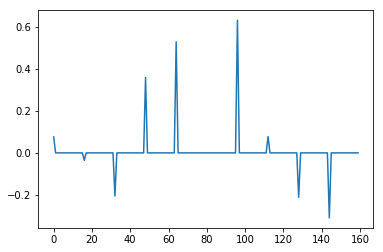

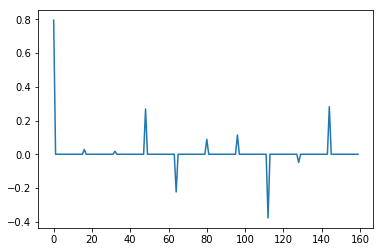

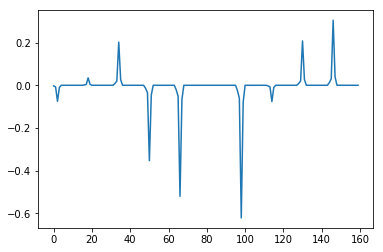

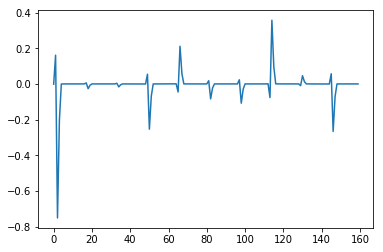

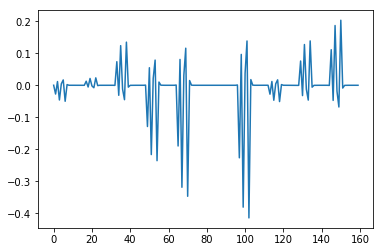

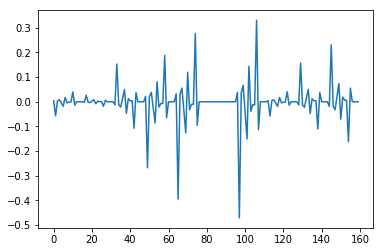

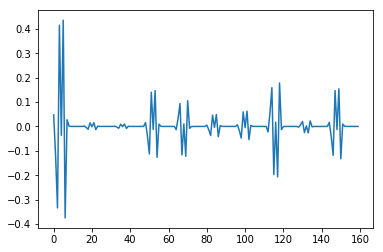

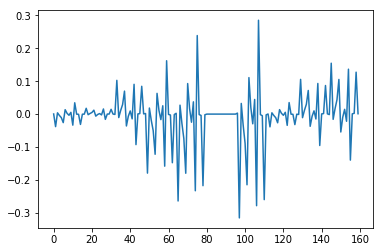

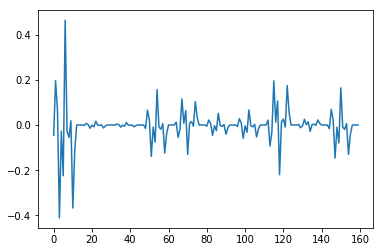

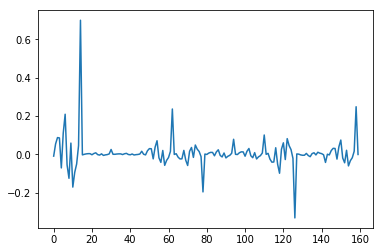

In [109]:
for i in range (10):
    plt.figure()
    plt.plot(range(f*nc), evecs.cpu().numpy()[:,i])#, marker = '*', linestyle='None')
    plt.show()

# Create Target

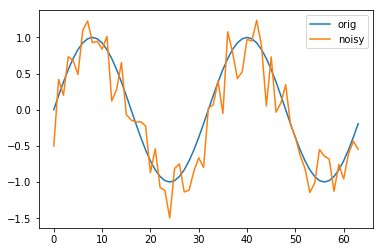

In [110]:
X_OUTPUT = np.arange(n)

#y0 = np.ones(n)
y0 = np.sin(2 *2*np.pi *X_OUTPUT / n)
#y0 = evecs.cpu().numpy()[0:n,i]
y0_noisy = y0 + 0.3 * np.random.randn(n)

y = torch.tensor(y0).type(dtype)
y_noisy = torch.tensor(y0_noisy).type(dtype)

if(CUDA):
    y = y.cuda()
    y_noisy = y_noisy.cuda()

plt.figure()
plt.plot(X_OUTPUT, y0, label='orig')
plt.plot(X_OUTPUT, y0_noisy, label='noisy')
plt.legend()
plt.show()

# Perform Linear Regression

In [111]:
stepsize = 1e-4
NUM_ITER = 1000

weights, log_noisy, log = gradient_descent(y_noisy, Z, weights, stepsize, NUM_ITER, CUDA, True, y)

#weights_noisy, log_noisy = gradient_descent(y_noisy, Z_noisy, weights_noisy, stepsize, NUM_ITER, CUDA)

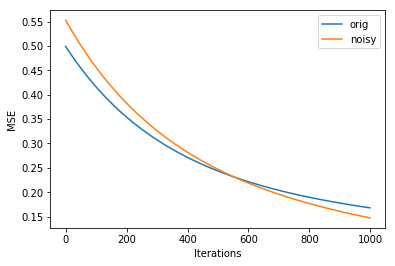

In [112]:
plt.figure()
plt.plot(range(NUM_ITER), log.cpu().numpy(), label='orig')
plt.plot(range(NUM_ITER), log_noisy.cpu().numpy(), label='noisy')
#plt.yscale("log")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Iterations")
plt.show()